# TP2 : Premier Réseau de neurones artificiels
## **Réalisé par Hugo et Teddy**

Ce note book propose plusieurs modèles avec une analyse de leurs performances 

## 1 IMPORT ET SETTINGS



In [1]:
# Tous les paquets sont déjà installés dans l’environnement conda
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import cv2
import warnings

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
from skimage import exposure
import zipfile
from PIL import Image
import datetime

%load_ext tensorboard

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation

print(tf.__version__)


2025-12-09 13:12:47.717956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


## 2. DATASET EXPLORATION 

remarque : modifiez les chemins vers les fichiers et les dossiers pour correspondre à l'organisation de votre Drive

In [2]:

#ds_file_zip = "/content/drive/MyDrive/SE-5104A/tp/archive.zip"
# !unzip fichier_à_décompresser -d dossier dans lequel il faut décompresser les données
#!unzip "/content/drive/MyDrive/SE-5104A/tp/archive.zip" -d "/content/drive/MyDrive/SE-5104A/tp/dataset/"

path_ds = '/Users/hugo/Desktop/TPs_IA_embarquée/TP2'
print(os.listdir(path_ds))
print( os.listdir(os.path.join(path_ds,'train')))

['Modele_v4.h5', 'Modele_v1.h5', 'test', 'meta', 'Complet.py', 'TP2_RoadSignNetwork.ipynb', 'FINAL.ipynb', 'logs', '33.png', 'train', 'Modele_v2.h5', '.git', 'Modele_v3.h5', '2.jpg', '.conda', 'image.png', 'Rapport']
['32', '35', '34', '33', '20', '18', '27', '9', '0', '11', '7', '29', '16', '42', '6', '28', '17', '1', '10', '19', '26', '8', '21', '38', '36', '31', '30', '37', '39', '41', '24', '23', '4', '15', '3', '12', '40', '2', '13', '5', '14', '22', '25']


# 3. DATASET LOADING AND PREPROCESSING

Maintenant, on vas préparer les données pour l'utilisation pour l'entrainement et on en profite pour regarder quelques images dans le dataset. Les étapes sont les suivantes


1.   Lire les images dans les dossiers du répértoire dataset (0,1,2..), ces sont les classes à reconnaitre
2.   Réunir dans deux np.array distints
    - les images redimensionnées à 30x30
    - les numéros des labels correspondants à chaque image

3. Dans l'étape d'amélioration des résultats, vous devez égaliser l'histogramme des images (enlever les effets d'un mauvais éclairage)
 image = exposure.equalize_adapthist(image, clip_limit=0.1)

In [ ]:
data = [] # ici je vais stocker les images
labels = [] # ici les labels
classes = 43 # c'est le nombre de classes dans le dataset
n_learned_classes = classes # alias pour manipuler plus facielement le nombre de classes


# Retrieving the images and their labels
for i in range(n_learned_classes): # Boucle sur les classes
    path = os.path.join(path_ds,'train',str(i))
    images = os.listdir(path)
    print ('Classe : ' + str(i), len(images)) # on affiche le nombre d'images par classes pour vérifier la cohérence du dataset

    for a in images: # Boucle sur les images
        try:
            image = Image.open(path + '/' + a  ) # on ouvre
            image = image.resize((30,30)) # On redimension l'image en 30x30 pixels
            # ces deux lignes si-dessous, on va les utiliser plus tard
            image = np.array(image) # on convertit en tableau numpy HxLxC donc 30x30x3
            # placer ici une équalisation de l'histogramme de l'image
            image =  exposure.equalize_adapthist(image, clip_limit=0.1)# On vient rendre les images plus lisibles
            data.append(image)# On ajoute l'image dans la liste data
            labels.append(i)#on ajoute le label dans la liste labels
        except:
            print("Error loading image") # Si une image ne peut pas être chargée, message d'erreur


data = np.array(data)#On convertit la liste en tableau numpy car mieux pour ccn
labels = np.array(labels)#idem
print(data.size)
print(labels.size)

Classe : 0 210
Classe : 1 66
Classe : 2 453
Classe : 3 644
Classe : 4 809
Classe : 5 868
Classe : 6 420
Classe : 7 638
Classe : 8 622
Classe : 9 690
Classe : 10 833
Classe : 11 605
Classe : 12 503
Classe : 13 560
Classe : 14 780
Classe : 15 630
Classe : 16 420
Classe : 17 916
Classe : 18 522
Classe : 19 210
Classe : 20 360
Classe : 21 330
Classe : 22 390
Classe : 23 510
Classe : 24 270
Classe : 25 688
Classe : 26 600
Classe : 27 240
Classe : 28 540
Classe : 29 270
Classe : 30 450
Classe : 31 780
Classe : 32 240
Classe : 33 689
Classe : 34 420
Classe : 35 518
Classe : 36 390
Classe : 37 210
Classe : 38 921
Classe : 39 300
Classe : 40 360
Classe : 41 240
Classe : 42 240
57658500
21355


Répartition des classes dans le dataset juste pour voir si il y a des classes sous représentées


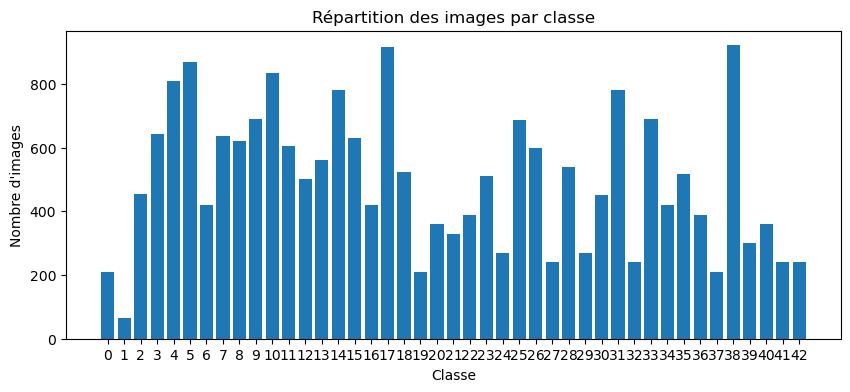

In [4]:
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10,4))
plt.bar(unique, counts)
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe")
plt.xticks(unique)
plt.show()

On regarde à quoi cela ressemble. Par exemple :

In [ ]:
for j in  range(800,805):
  plt.figure()
  plt.imshow(data[j,:,:,:])

préparer les ensembles de données bien formatées pour l'apprentissage -> vérifions les dimensions, l'encodage des classes (one-hot) et puis coupons le dataset en partie : training et validation

In [5]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

train_ds = image_dataset_from_directory(
    "train",
    image_size=(30, 30),
    batch_size=32,
    shuffle=True
)

(21355, 30, 30, 3) (21355,)
(17084, 30, 30, 3) (4271, 30, 30, 3) (17084,) (4271,)
Found 21355 files belonging to 43 classes.


2025-12-09 13:17:22.225380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 4. Les différents modèles

On est prêt, on peut construire nos premiers modèles de réseaux de neurons artificiels. On va commencer par combiner les couches pleinement connectées (on n'a pas travaillé d'autres en classes)

- V1 : 2 couches pleinement connectées 
- V2 : 3 couches au minimum pleinement connectées 
- V3 : 2 couches pleinement connectées précdées par une couche convolutive (placée devant couche flatten).
- V4 (optionnelle) modèle personnel 

## **modèle 1**

In [ ]:
from tensorflow import keras


model_v1 = Sequential()

model_v1.add(keras.Input(shape=X_train.shape[1:]))

model_v1.add(Flatten())

model_v1.add(Dense(512, activation='relu'))   # 1ère couche Dense
model_v1.add(Dense(256, activation='relu'))   # 2ème couche Dense

model_v1.add(Dense(43, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v1.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

model_v1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2700)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               1382912   
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 43)                11051     
                                                                 
Total params: 1,525,291
Trainable params: 1,525,291
Non-trainable params: 0
_________________________________________________________________


Entrainement du réseau et évaluations des performances

In [34]:
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_v1=model_v1.fit(x=X_train,
          y=y_train,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/50
1068/1068 [==============================] - 12s 10ms/step - loss: 1.8962 - accuracy: 0.5428 - val_loss: 0.9742 - val_accuracy: 0.7619
Epoch 2/50
1068/1068 [==============================] - 8s 8ms/step - loss: 0.6895 - accuracy: 0.8345 - val_loss: 0.5401 - val_accuracy: 0.8705
Epoch 3/50
1068/1068 [==============================] - 10s 10ms/step - loss: 0.4195 - accuracy: 0.9018 - val_loss: 0.4331 - val_accuracy: 0.8850
Epoch 4/50
1068/1068 [==============================] - 10s 9ms/step - loss: 0.3140 - accuracy: 0.9250 - val_loss: 0.3502 - val_accuracy: 0.9070
Epoch 5/50
1068/1068 [==============================] - 9s 8ms/step - loss: 0.2440 - accuracy: 0.9405 - val_loss: 0.3185 - val_accuracy: 0.9138
Epoch 6/50
1068/1068 [==============================] - 10s 10ms/step - loss: 0.1957 - accuracy: 0.9535 - val_loss: 0.2741 - val_accuracy: 0.9166
Epoch 7/50
1068/1068 [==============================] - 9s 9ms/step - loss: 0.1697 - accuracy: 0.9582 - val_loss: 0.2538 - val_ac

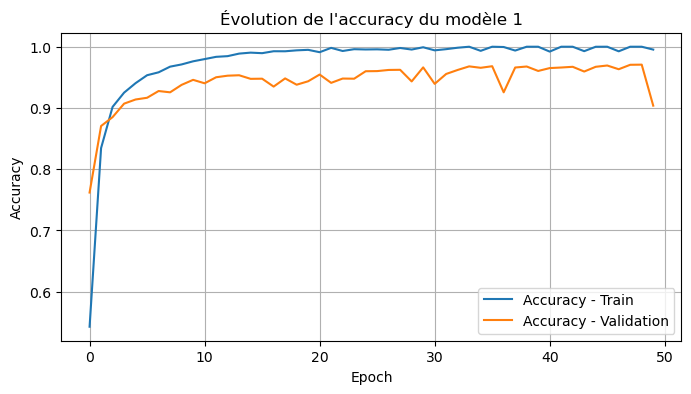

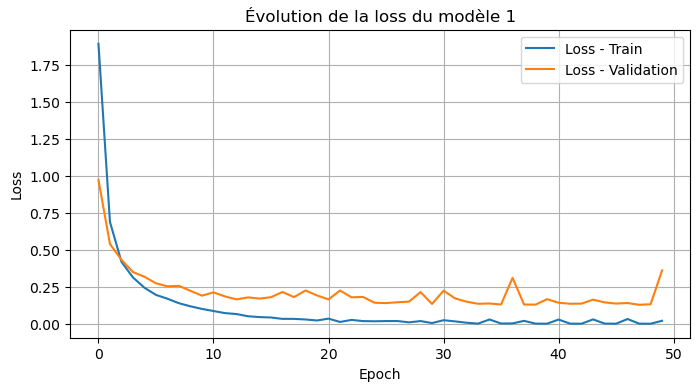

In [44]:
# Visualisation des courbes d'apprentissage

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history_v1.history['accuracy'], label='Accuracy - Train')
plt.plot(history_v1.history['val_accuracy'], label='Accuracy - Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Évolution de l'accuracy du modèle 1")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(history_v1.history['loss'], label='Loss - Train')
plt.plot(history_v1.history['val_loss'], label='Loss - Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Évolution de la loss du modèle 1")
plt.legend()
plt.grid(True)
plt.show()

test du modèle


1/1 [==============================] - 0s 96ms/step


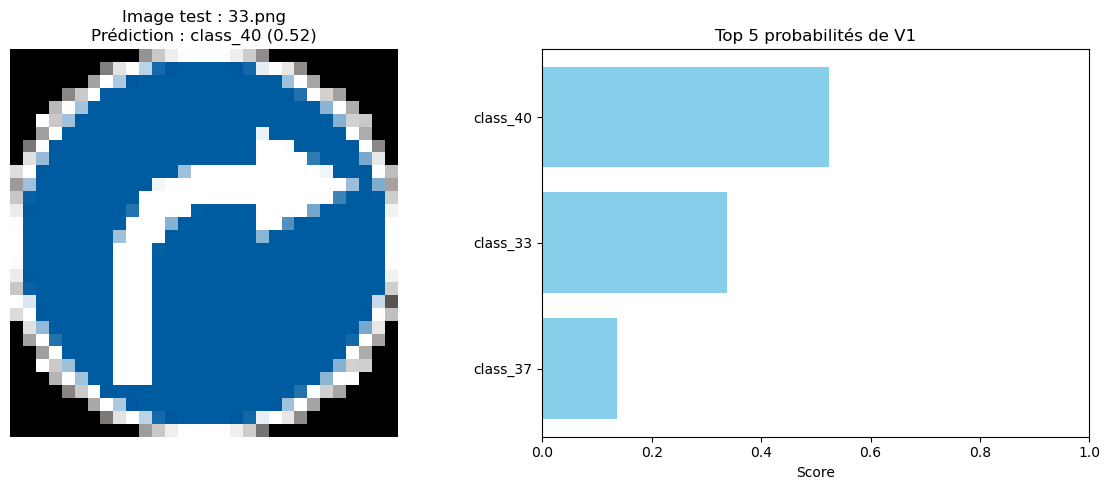


Top prédictions :
class_40             -> 0.524
class_33             -> 0.337
class_37             -> 0.136


In [ ]:
IMG_PATH = "33.png"
IMG_SIZE = (X_train.shape[1],X_train.shape[2])
N_CLASSES = 43

class_names = [f"class_{i}" for i in range(N_CLASSES)]

img = load_img(IMG_PATH, target_size=IMG_SIZE)
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)# (1, H, W, 3)

preds = model_v1.predict(x)[0]
top_k = 3 
top_idx = np.argsort(preds)[-top_k:][::-1]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
best_class = class_names[top_idx[0]]
best_proba = preds[top_idx[0]]
plt.title(f"Image test : {IMG_PATH}\nPrédiction : {best_class} ({best_proba:.2f})")

plt.subplot(1,2,2)
labels = [class_names[i] for i in top_idx]
values = preds[top_idx]
plt.barh(labels, values, color="skyblue")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title("Top 5 probabilités de V1")
plt.xlabel("Score")
plt.tight_layout()

plt.show()

print("\nTop prédictions :")
for i in top_idx:
    print(f"{class_names[i]:20s} -> {preds[i]:.3f}")


In [51]:
model_v1.save('Modele_v1.h5')

## **modèle 2**

In [ ]:
from tensorflow import keras

model_v2 = Sequential()

model_v2.add(keras.Input(shape=X_train.shape[1:]))

model_v2.add(Flatten())

model_v2.add(Dense(512, activation='relu'))   
model_v2.add(Dense(256, activation='relu'))   
model_v2.add(Dense(128, activation='relu'))   

model_v2.add(Dense(43, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

model_v2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2700)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               1382912   
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 43)                5547      
                                                                 
Total params: 1,552,683
Trainable params: 1,552,683
Non-trainable params: 0
_________________________________________________________________


In [38]:
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history=model_v2.fit(x=X_train,
          y=y_train,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/50
1068/1068 [==============================] - 14s 12ms/step - loss: 2.0420 - accuracy: 0.4968 - val_loss: 0.9570 - val_accuracy: 0.7776
Epoch 2/50
1068/1068 [==============================] - 10s 10ms/step - loss: 0.7095 - accuracy: 0.8219 - val_loss: 0.5317 - val_accuracy: 0.8649
Epoch 3/50
1068/1068 [==============================] - 8s 8ms/step - loss: 0.4445 - accuracy: 0.8887 - val_loss: 0.4484 - val_accuracy: 0.8839
Epoch 4/50
1068/1068 [==============================] - 10s 10ms/step - loss: 0.3338 - accuracy: 0.9128 - val_loss: 0.3588 - val_accuracy: 0.9024
Epoch 5/50
1068/1068 [==============================] - 10s 9ms/step - loss: 0.2686 - accuracy: 0.9312 - val_loss: 0.2856 - val_accuracy: 0.9248
Epoch 6/50
1068/1068 [==============================] - 9s 8ms/step - loss: 0.2221 - accuracy: 0.9423 - val_loss: 0.3171 - val_accuracy: 0.9122
Epoch 7/50
1068/1068 [==============================] - 11s 10ms/step - loss: 0.1859 - accuracy: 0.9504 - val_loss: 0.2734 - val_

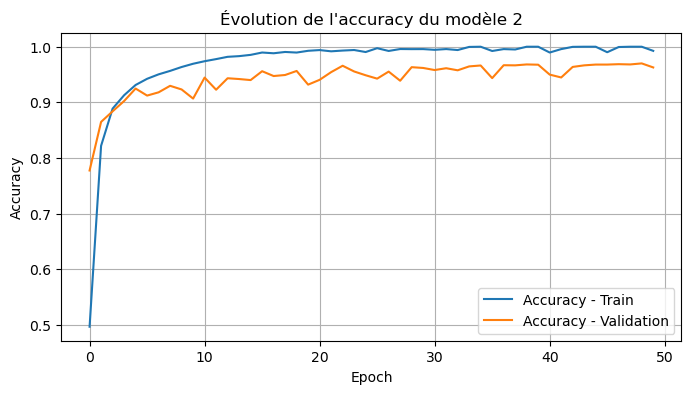

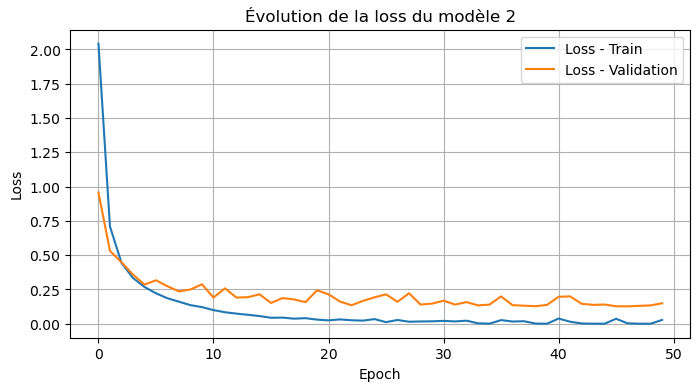

In [43]:
# Visualisation des courbes d'apprentissage

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Accuracy - Train')
plt.plot(history.history['val_accuracy'], label='Accuracy - Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Évolution de l'accuracy du modèle 2")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Loss - Train')
plt.plot(history.history['val_loss'], label='Loss - Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Évolution de la loss du modèle 2")
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 69ms/step


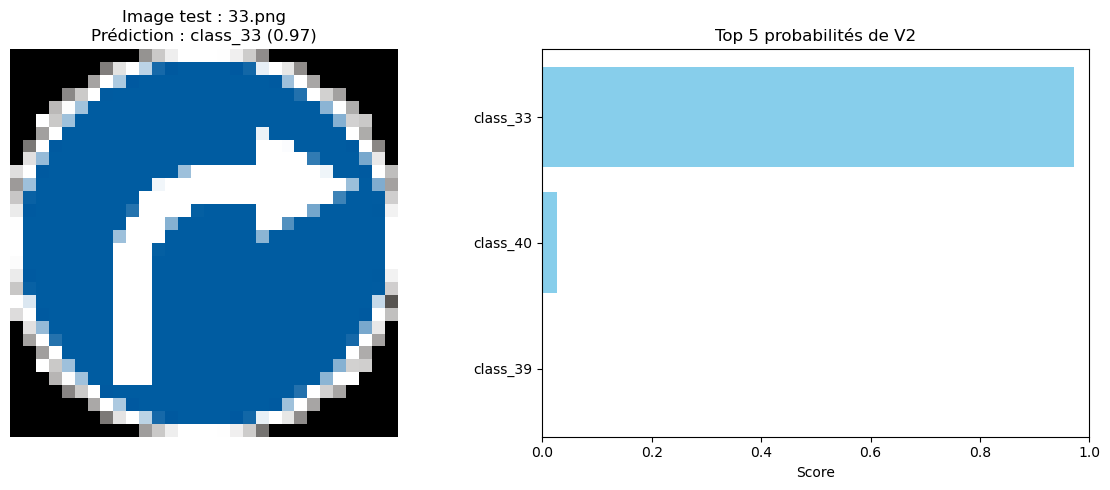


Top prédictions :
class_33             -> 0.973
class_40             -> 0.027
class_39             -> 0.000


In [ ]:
IMG_PATH = "33.png"
IMG_SIZE = (X_train.shape[1],X_train.shape[2])
N_CLASSES = 43#nombre de classes du dataset

class_names = [f"class_{i}" for i in range(N_CLASSES)]

img = load_img(IMG_PATH, target_size=IMG_SIZE)
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)# (1, H, W, 3)

preds = model_v2.predict(x)[0]
top_k = 3 # top 3 
top_idx = np.argsort(preds)[-top_k:][::-1]

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
best_class = class_names[top_idx[0]]
best_proba = preds[top_idx[0]]
plt.title(f"Image test : {IMG_PATH}\nPrédiction : {best_class} ({best_proba:.2f})")

plt.subplot(1,2,2)
labels = [class_names[i] for i in top_idx]
values = preds[top_idx]
plt.barh(labels, values, color="skyblue")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title("Top 5 probabilités de V2")
plt.xlabel("Score")
plt.tight_layout()

plt.show()

print("\nTop prédictions :")
for i in top_idx:
    print(f"{class_names[i]:20s} -> {preds[i]:.3f}")


In [50]:
model_v2.save('Modele_v2.h5')

## **Modèle 3**

In [ ]:
from tensorflow import keras

#  1 conv + Flatten + 2 Dense


model_v3 = Sequential()

model_v3.add(keras.Input(shape=X_train.shape[1:]))

model_v3.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))

model_v3.add(MaxPool2D(pool_size=(2, 2)))

model_v3.add(Flatten())

model_v3.add(Dense(256, activation='relu'))

model_v3.add(Dense(43, activation='softmax'))   

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v3.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

model_v3.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        2432      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 5408)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               1384704   
                                                                 
 dense_19 (Dense)            (None, 43)                11051     
                                                                 
Total params: 1,398,187
Trainable params: 1,398,187
Non-trainable params: 0
____________________________________________

In [41]:
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_v3=model_v3.fit(x=X_train,
          y=y_train,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/50
1068/1068 [==============================] - 17s 15ms/step - loss: 1.5751 - accuracy: 0.6344 - val_loss: 0.5894 - val_accuracy: 0.8558
Epoch 2/50
1068/1068 [==============================] - 15s 14ms/step - loss: 0.3882 - accuracy: 0.9110 - val_loss: 0.2886 - val_accuracy: 0.9307
Epoch 3/50
1068/1068 [==============================] - 15s 14ms/step - loss: 0.2040 - accuracy: 0.9550 - val_loss: 0.1916 - val_accuracy: 0.9546
Epoch 4/50
1068/1068 [==============================] - 13s 12ms/step - loss: 0.1274 - accuracy: 0.9728 - val_loss: 0.1509 - val_accuracy: 0.9646
Epoch 5/50
1068/1068 [==============================] - 13s 12ms/step - loss: 0.0832 - accuracy: 0.9833 - val_loss: 0.1349 - val_accuracy: 0.9689
Epoch 6/50
1068/1068 [==============================] - 13s 12ms/step - loss: 0.0542 - accuracy: 0.9903 - val_loss: 0.1040 - val_accuracy: 0.9752
Epoch 7/50
1068/1068 [==============================] - 13s 12ms/step - loss: 0.0345 - accuracy: 0.9951 - val_loss: 0.0959 -

1/1 [==============================] - 0s 131ms/step


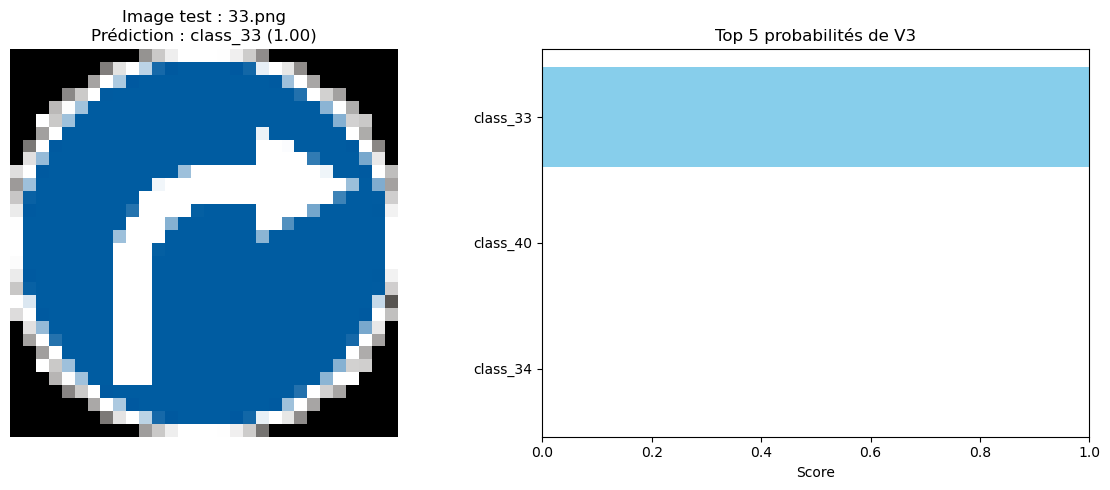


Top prédictions :
class_33             -> 1.000
class_40             -> 0.000
class_34             -> 0.000


In [ ]:
IMG_PATH = "33.png"
IMG_SIZE = (X_train.shape[1],X_train.shape[2])
N_CLASSES = 43

class_names = [f"class_{i}" for i in range(N_CLASSES)]

img = load_img(IMG_PATH, target_size=IMG_SIZE)
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)# (1, H, W, 3)


preds = model_v3.predict(x)[0]
top_k = 3 
top_idx = np.argsort(preds)[-top_k:][::-1]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
best_class = class_names[top_idx[0]]
best_proba = preds[top_idx[0]]
plt.title(f"Image test : {IMG_PATH}\nPrédiction : {best_class} ({best_proba:.2f})")

plt.subplot(1,2,2)
labels = [class_names[i] for i in top_idx]
values = preds[top_idx]
plt.barh(labels, values, color="skyblue")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title("Top 5 probabilités de V3")
plt.xlabel("Score")
plt.tight_layout()

plt.show()

print("\nTop prédictions :")
for i in top_idx:
    print(f"{class_names[i]:20s} -> {preds[i]:.3f}")


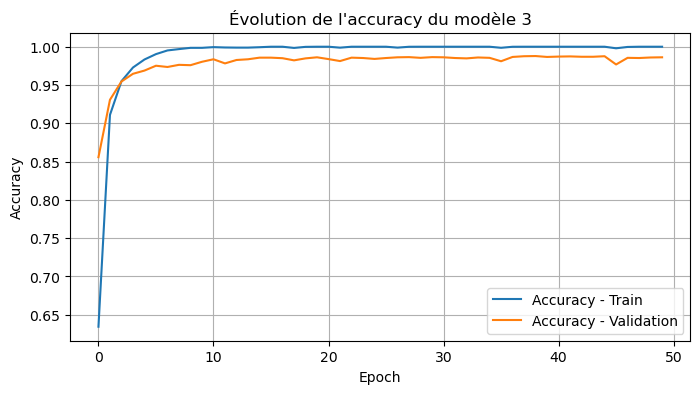

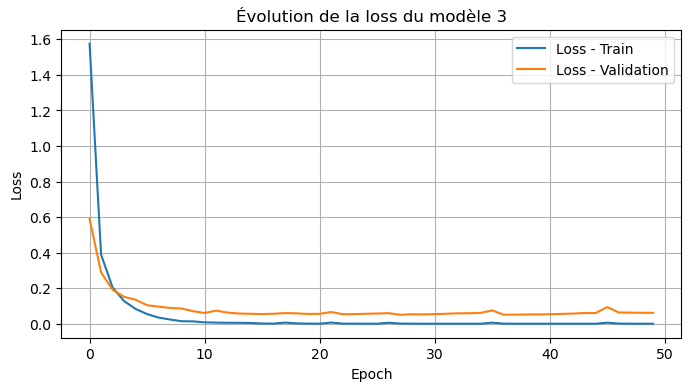

In [45]:
# Visualisation des courbes d'apprentissage

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history_v3.history['accuracy'], label='Accuracy - Train')
plt.plot(history_v3.history['val_accuracy'], label='Accuracy - Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Évolution de l'accuracy du modèle 3")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(history_v3.history['loss'], label='Loss - Train')
plt.plot(history_v3.history['val_loss'], label='Loss - Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Évolution de la loss du modèle 3")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
model_v3.save('Modele_v3.h5')

## **Modèle 4**

In [ ]:
from tensorflow import keras

model_v4 = Sequential()

model_v4.add(keras.Input(shape=X_train.shape[1:]))

# Conv 1
model_v4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_v4.add(MaxPool2D(pool_size=(2, 2)))

# Conv 2
model_v4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_v4.add(MaxPool2D(pool_size=(2, 2)))

# Conv 3
model_v4.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_v4.add(MaxPool2D(pool_size=(2, 2)))

model_v4.add(Flatten())

model_v4.add(Dense(512, activation='relu'))
model_v4.add(Dropout(rate=0.5))        # on “éteint” aléatoirement 50% des neurones pendant l'entraînement

model_v4.add(Dense(256, activation='relu'))
model_v4.add(Dropout(rate=0.5))

model_v4.add(Dense(43, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v4.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

model_v4.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 128)       

In [28]:
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_v4=model_v4.fit(x=X_train,
          y=y_train,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/50
1068/1068 [==============================] - 32s 29ms/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0242 - val_accuracy: 0.9944
Epoch 2/50
1068/1068 [==============================] - 27s 25ms/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.0191 - val_accuracy: 0.9944
Epoch 3/50
1068/1068 [==============================] - 34s 32ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0205 - val_accuracy: 0.9956
Epoch 4/50
1068/1068 [==============================] - 26s 24ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0252 - val_accuracy: 0.9944
Epoch 5/50
1068/1068 [==============================] - 283s 266ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0236 - val_accuracy: 0.9946
Epoch 6/50
1068/1068 [==============================] - 29s 27ms/step - loss: 0.0080 - accuracy: 0.9974 - val_loss: 0.0236 - val_accuracy: 0.9946
Epoch 7/50
1068/1068 [==============================] - 29s 27ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0264

1/1 [==============================] - 0s 35ms/step


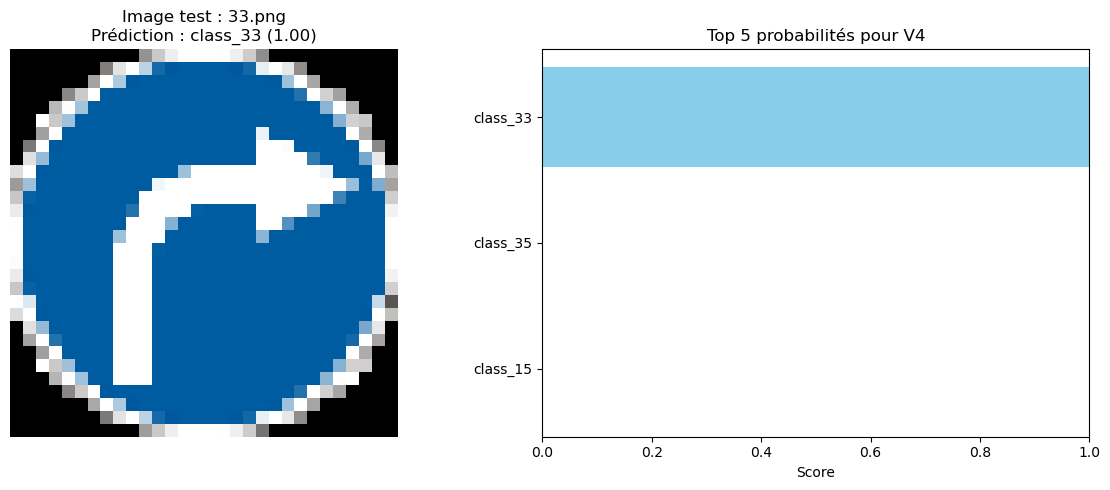


Top prédictions :
class_33             -> 1.000
class_35             -> 0.000
class_15             -> 0.000


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_PATH = "33.png"
IMG_SIZE = (X_train.shape[1],X_train.shape[2])
N_CLASSES = 43

class_names = [f"class_{i}" for i in range(N_CLASSES)]

img = load_img(IMG_PATH, target_size=IMG_SIZE)
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)# (1, H, W, 3)

preds = model_v4.predict(x)[0]
top_k = 3 
top_idx = np.argsort(preds)[-top_k:][::-1]


plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
best_class = class_names[top_idx[0]]
best_proba = preds[top_idx[0]]
plt.title(f"Image test : {IMG_PATH}\nPrédiction : {best_class} ({best_proba:.2f})")

plt.subplot(1,2,2)
labels = [class_names[i] for i in top_idx]
values = preds[top_idx]
plt.barh(labels, values, color="skyblue")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title("Top 5 probabilités pour V4")
plt.xlabel("Score")
plt.tight_layout()

plt.show()

print("\nTop prédictions :")
for i in top_idx:
    print(f"{class_names[i]:20s} -> {preds[i]:.3f}")


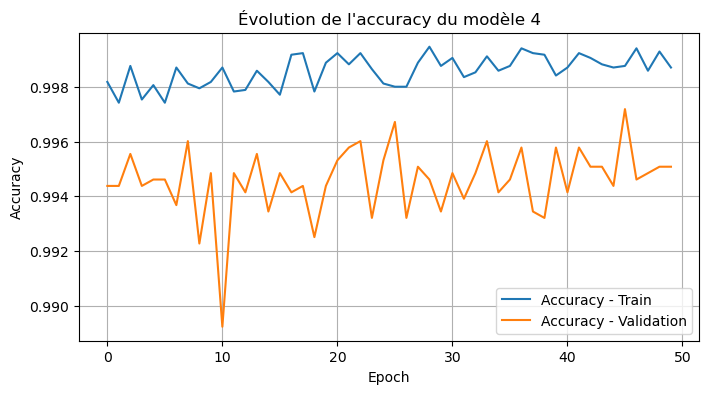

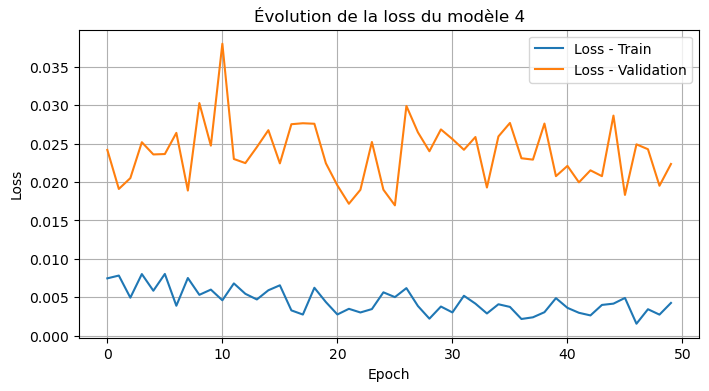

In [46]:
# Visualisation des courbes d'apprentissage

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history_v4.history['accuracy'], label='Accuracy - Train')
plt.plot(history_v4.history['val_accuracy'], label='Accuracy - Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Évolution de l'accuracy du modèle 4")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(history_v4.history['loss'], label='Loss - Train')
plt.plot(history_v4.history['val_loss'], label='Loss - Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Évolution de la loss du modèle 4")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
model_v4.save('Modele_v4.h5')

134/134 [==============================] - 1s 4ms/step


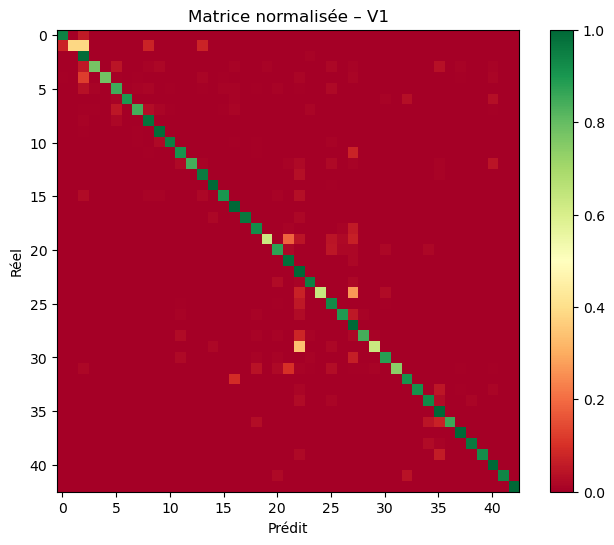

134/134 [==============================] - 1s 4ms/step


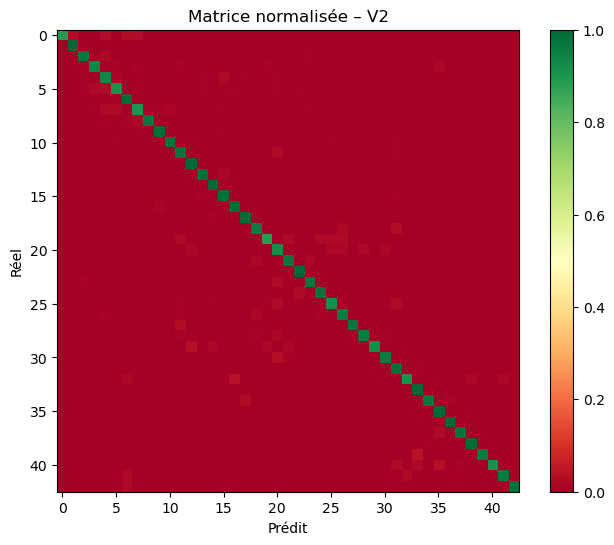

134/134 [==============================] - 1s 8ms/step


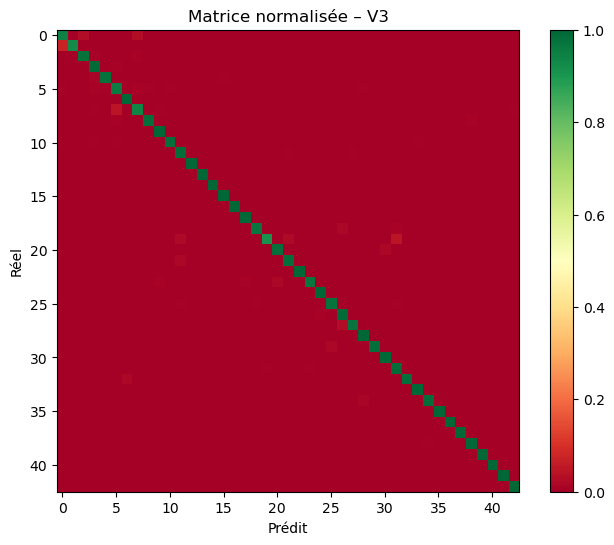

134/134 [==============================] - 2s 14ms/step


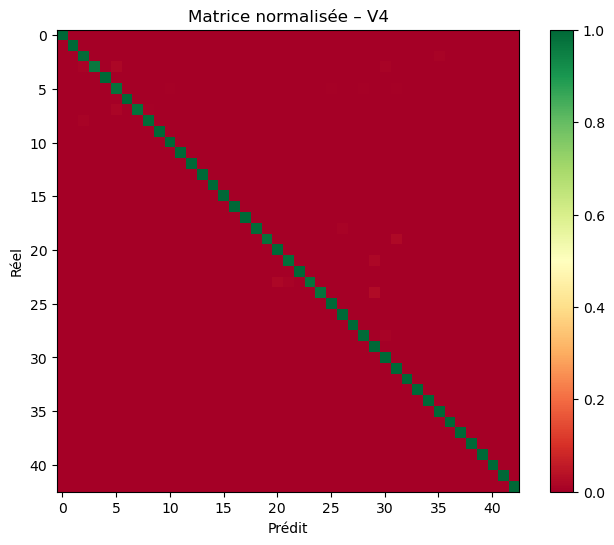

In [48]:
from sklearn.metrics import confusion_matrix
y_true = np.argmax(y_test, axis=1)


def plot_normalized_confusion_matrix(model, X_test, y_true, title):
    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize="true")

    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="RdYlGn", vmin=0, vmax=1)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

plot_normalized_confusion_matrix(model_v1, X_test, y_true, "Matrice normalisée – V1")
plot_normalized_confusion_matrix(model_v2, X_test, y_true, "Matrice normalisée – V2")
plot_normalized_confusion_matrix(model_v3, X_test, y_true, "Matrice normalisée – V3")
plot_normalized_confusion_matrix(model_v4, X_test, y_true, "Matrice normalisée – V4")
